<img src="./images/DLI_Header.png" style="width: 400px;">

# 전이 학습(Transfer Learning)

지금까지 대규모 데이터세트에 대해 정확한 모델을 트레이닝했으며 트레이닝할 필요없이 사용한 사전 트레이닝된 모델도 다운로드했습니다. 하지만 정확히 필요한 작업을 수행하는 사전 트레이닝된 모델을 찾을 수 없거나 모델을 처음부터 트레이닝하기 위한 충분히 큰 데이터세트가 없는 경우에는 어떻게 해야 할까요? 이 경우에는 [전이 학습](https://blogs.nvidia.com/blog/2019/02/07/what-is-transfer-learning/)이라는 매우 유용한 기술을 사용할 수 있습니다.

전이 학습을 사용하면 사전 트레이닝된 모델을 원래의 트레이닝 작업과 어느 정도 중첩되는 작업에 대해 다시 트레이닝할 수 있습니다. 수채화에 능하지만 목탄화도 연습하고 싶어하는 화가를 좋은 예로 들 수 있습니다. 수채화를 그리면서 배운 기술은 목탄화 그리는 법을 배우는 데 매우 유용할 것입니다. 

딥러닝의 예로, 다양한 유형의 자동차를 인식하는 성능이 뛰어난 사전 트레이닝된 모델이 있고 이 모델이 모터사이클 유형을 인식하도록 트레이닝하려 한다고 가정해 보겠습니다. 전조등 및 휠 인식 능력을 비롯한 자동차 모델의 수많은 학습이 매우 유용할 가능성이 높습니다. 

전이 학습은 크고 다양한 데이터세트가 없는 경우에 특히 강력한효과가 있습니다. 이런 경우에는 처음부터 트레이닝된 모델이 트레이닝 데이터를 빠르게 기억할 가능성이 높지만 새 데이터를 제대로 일반화할 수 없습니다. 전이 학습을 이용하면 소규모 데이터세트에 대해 정확하고 강력한 모델을 트레이닝할 수 있는 가능성을 높일 수 있습니다.

## 목표

* 전이 학습을 위한 사전 트레이닝된 모델 준비
* 사전 트레이닝된 모델로 자체적인 소규모 데이터세트에 대해 전이 학습 수행
* 훨씬 더 나은 성능을 위해 모델을 추가로 파인튜닝

## 맞춤형 분류기

지난 연습에서는 사전 트레이닝된 [ImageNet](http://www.image-net.org/) 모델을 사용하여 개만 출입을 허용하고 다른 동물들의 출입은 막아 보았습니다. 이 연습에서는 특정한 개만 출입 가능한 개구멍을 만들어 보려고 합니다. 이 경우에는 2009년부터 2017년까지 미국의 퍼스트 독이었던 Bo라는 개를 위한 자동 개구멍을 만들어 보겠습니다. `presidential_doggy_door` 폴더에 Bo의 사진이 더 있습니다.

<img src="data/presidential_doggy_door/train/bo/bo_10.jpg">

문제는 사전 트레이닝된 모델이 이 특정 개를 인식하도록 트레이닝되지 않았으며 우리에게 Bo의 사진이 30개밖에 없다는 것입니다. 30개의 사진을 사용하여 모델을 처음부터 트레이닝하려고 할 경우 과적합과 저조한 일반화를 경험하게 됩니다. 하지만 개를 검출하는 데 능숙한 사전 트레이닝된 모델로 시작하면 이러한 학습을 활용하여 더 작은 데이터세트로도 Bo에 대한 일반화된 이해도를 얻을 수 있습니다. 전이 학습을 사용하여 이 문제를 해결할 수 있습니다.

## 사전 트레이닝된 모델 다운로드

[ImageNet 사전 트레이닝된 모델](https://keras.io/api/applications/vgg/#vgg16-function)이 컴퓨터 비전 전이 학습에 적합한 경우가 많은 이유는 다양한 유형의 이미지를 분류하도록 학습했기 때문입니다. 이 과정에서 모델은 이미지 인식에서 중요할 수 있는 수많은 다양한 유형의 [특징](https://developers.google.com/machine-learning/glossary#)을 검출하는 법을 학습했습니다. ImageNet 모델은 개를 비롯한 동물을 검출하는 법을 학습했으므로 Bo를 검출하기 위한 이 전이 학습 작업에 특히 적합합니다.

먼저 사전 트레이닝된 모델을 다운로드하겠습니다. 마찬가지로 이 모델은 Keras 라이브러리에서 바로 가져올 수 있습니다. 다운로드 과정에서는 중요한 차이점에 발생하게 됩니다. ImageNet 모델의 마지막 레이어는 데이터세트에서 1,000개의 가능한 클래스를 나타내는 1,000개의 유닛으로 이루어진 [밀집 레이어](https://developers.google.com/machine-learning/glossary#dense-layer)입니다. 여기서는 다른 분류를 수행하도록 해야 합니다. 즉, Bo인지 아닌지를 분류하도록 해야 합니다. 다르게 분류를 해야 하므로 모델의 마지막 레이어를 제거하겠습니다. 이렇게 하려면 모델을 다운로드할 때 플래그 `include_top=False`를 설정하면 됩니다. 이 맨 위 레이어를 제거한 후에는 우리가 원하는 분류 유형을 제공할 새 레이어를 추가할 수 있습니다.

In [1]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

2022-04-09 14:15:27.850746: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-09 14:15:27.878876: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbd8ed47af0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-09 14:15:27.878893: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [2]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 기본 모델 동결
새 레이어를 [사전 트레이닝된 모델](https://developers.google.com/machine-learning/glossary#pre-trained-model)에 추가하기 전에 수행해야 할 중요한 단계가 있습니다. 모델의 사전 트레이닝된 레이어를 동결하는 것입니다. 즉, 트레이닝할 때 사전 트레이닝된 모델에서 기본 레이어는 업데이트하지 않는 것입니다. 대신 새로운 분류를 위해 우리가 끝에 추가하는 새 레이어만 업데이트하게 됩니다. 초기 레이어를 동결하는 이유는 ImageNet 데이터세트에 대한 트레이닝에서 달성한 학습을 유지해야 하기 때문입니다. 이 단계에서 동결 해제된 경우에는 이 중요한 정보가 손실될 가능성이 높습니다 나중에 파인튜닝이라는 과정에서 이러한 레이어를 동결 해제하고 트레이닝할 수 있는 옵션이 있습니다.

기본 레이어를 동결하는 것은 모델에 대해 트레이닝 가능을 `False`로 설정하는 것 만큼이나 간단합니다.

In [3]:
base_model.trainable = False

## 새 레이어 추가

이제 트레이닝 가능한 새 레이어를 사전 트레이닝된 모델에 추가할 수 있습니다. 새 레이어는 사전 트레이닝된 레이어의 피처를 취해 새 데이터세트에 대한 예측으로 변환합니다. 모델에 두 개의 레이어를 추가하겠습니다. 첫 번째는 이전의 [CNN(Convolutional Neural Network)](https://developers.google.com/machine-learning/glossary#convolutional_layer)에서 봤던 풀링 레이어입니다. (CNN에서 풀링 레이어의 역할에 대해 좀 더 자세히 이해하고 싶은 경우 [이 상세 블로그 게시물](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/#:~:text=A%20pooling%20layer%20is%20a,Convolutional%20Layer) 참조). 그런 다음에는 Bo인지 아닌지를 분류할 마지막 레이어를 추가해야 합니다. 이는 한 개의 출력을 포함하는 밀접하게 연결된 레이어가 됩니다.

In [4]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

사전 트레이닝된 모델을 새 레이어와 결합했으니 이제 모델을 살펴보겠습니다.

In [5]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


Keras는 여기서 적절한 요약을 제공합니다. 내부 레이어 전체를 표시하는 대신 vgg16 사전 트레이닝된 모델을 하나의 유닛으로 보여주기 때문입니다. 또한 사전 트레이닝된 모델을 동결했으므로 트레이닝 불가한 다수의 매개변수도 있다는 점도 주목할 가치가 있습니다. 

## 모델 컴파일

이전 연습에서 그랬던 것처럼 손실 및 지표 옵션으로 모델을 컴파일해야 합니다. 여기서는 몇 가지 다른 선택을 해야 합니다. 이전 사례에서는 분류 문제에 다수의 범주가 있었습니다. 그래서 손실 계산을 위한 범주형 크로스 엔트로피를 선택했습니다. 이번 사례에서는 바이너리 분류 문제(Bo인지 아닌지 여부)만 있으므로 [바이너리 크로스 엔트로피](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)를 선택하겠습니다. 둘 사이의 차이점에 대한 자세한 내용은 [여기](https://gombru.github.io/2018/05/23/cross_entropy_loss/)에서 확인할 수 있습니다. 또한 기존 정확도 대신 바이너리 정확도를 사용합니다.

`from_logits=True`를 설정함으로써 출력 값이 softmax 등으로 정규화되지 않았음을 [손실 함수](https://gombru.github.io/2018/05/23/cross_entropy_loss/)에 알립니다.

In [6]:
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])  # metrics=[keras.metrics.BinaryAccuracy()]
# model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

## 데이터 증강

매우 작은 데이터세트를 다루고 있는 만큼 데이터를 증강하는 것이 특히 중요합니다. 전과 마찬가지로, 기존 이미지를 약간 수정하면 모델이 보다 광범위한 이미지를 확인하고 학습할 수 있습니다. 이는 단순히 트레이닝하는 사진만 기억하는 대신 Bo의 새로운 사진을 인식하는 법을 학습하는 데 도움이 됩니다.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically

## 데이터 로드

우리는 지금까지 몇 가지 형식의 데이터세트를 보았습니다. MNIST 연습에서는 Keras 라이브러리 내에서 바로 데이터세트를 다운로드할 수 있었습니다. 수화 데이터세트의 경우에는 데이터가 CSV 파일 형식이었습니다. 이 연습에서는 Keras의 [`flow_from_directory`](https://keras.io/api/preprocessing/image/) 함수를 사용하여 폴더에서 바로 이미지를 로드하겠습니다. 이러한 과정이 원활하게 이루어지도록 디렉토리를 설정해 놓았습니다. `presidential_doggy_door` 디렉토리에는 트레이닝 및 검증 디렉토리가 있으며, 각 디렉토리에는 Bo인 이미지와 Bo가 아닌 이미지를 위한 폴더가 있습니다. not_bo 디렉토리에는 다른 반려동물을 막도록 모델에 가르치기 위한 다른 개와 고양이의 사진이 있습니다. 자유롭게 미지를 살펴보며 데이터세트에 대한 감을 익히시기 바랍니다.

[flow_from_directory](https://keras.io/api/preprocessing/image/) 또한 모델에 맞게 이미지 크기를 변경할 수 있도록 해줍니다(244x244픽셀 및 3채널).

In [8]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('data/presidential_doggy_door/train', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode='binary', 
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('data/presidential_doggy_door/vaild', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

Found 132 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [9]:
train_it.class_indices


{'bo': 0, 'not_bo': 1}

In [10]:
# step 수 (epoch 당 몇번 weight를 update 할것인지)
len(train_it)

17

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


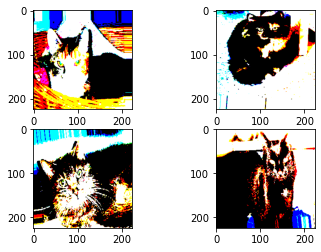

In [9]:
import matplotlib.pyplot as plt

batch = train_it.next() # batch 갯수 만큼 이미지 조회 
# print(batch)

plt.figsize=(10,10)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(batch[0][i])
plt.show()

## 모델 트레이닝

이제 모델을 트레이닝하고 성능을 확인해볼 시간입니다. 데이터 생성기를 사용했을 당시에는 `steps_per_epoch`의 수를 명확하게 설정해야 했습니다.

In [10]:
# model.fit(train_it, 
#           steps_per_epoch=17,  # 12                                                                                                                                                                                                                   , 
#           validation_data=valid_it, 
#           validation_steps=4, 
#           epochs=20)

history = model.fit(train_it, 
          steps_per_epoch=len(train_it),  # 12                                                                                                                                                                                                                   , 
          validation_data=valid_it, 
          validation_steps=len(valid_it), 
          epochs=20)

Epoch 1/20
17/17 [==============================] - 10s 594ms/step - loss: 0.7027 - accuracy: 0.7500 - val_loss: 1.6127 - val_accuracy: 0.7000
Epoch 2/20
17/17 [==============================] - 10s 590ms/step - loss: 0.3521 - accuracy: 0.8106 - val_loss: 2.0331 - val_accuracy: 0.6500
Epoch 3/20
17/17 [==============================] - 10s 598ms/step - loss: 0.1968 - accuracy: 0.9318 - val_loss: 0.7868 - val_accuracy: 0.8000
Epoch 4/20
17/17 [==============================] - 10s 600ms/step - loss: 0.1226 - accuracy: 0.9394 - val_loss: 0.8077 - val_accuracy: 0.7500
Epoch 5/20
17/17 [==============================] - 11s 619ms/step - loss: 0.0863 - accuracy: 0.9545 - val_loss: 0.7356 - val_accuracy: 0.8000
Epoch 6/20
17/17 [==============================] - 11s 618ms/step - loss: 0.0332 - accuracy: 0.9773 - val_loss: 0.4634 - val_accuracy: 0.8500
Epoch 7/20
17/17 [==============================] - 11s 627ms/step - loss: 0.0264 - accuracy: 0.9848 - val_loss: 0.3230 - val_accuracy: 0.9000

[0.75, 0.810606062412262, 0.9318181872367859, 0.939393937587738, 0.9545454382896423, 0.9772727489471436, 0.9848484992980957, 0.9848484992980957, 0.9924242496490479, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242496490479, 1.0, 1.0, 1.0, 1.0]
[0.699999988079071, 0.6499999761581421, 0.800000011920929, 0.75, 0.800000011920929, 0.8500000238418579, 0.8999999761581421, 0.800000011920929, 0.8999999761581421, 0.8999999761581421, 0.8500000238418579, 0.8999999761581421, 0.800000011920929, 0.949999988079071, 0.8999999761581421, 0.8500000238418579, 0.8999999761581421, 0.8500000238418579, 0.949999988079071, 0.8500000238418579]


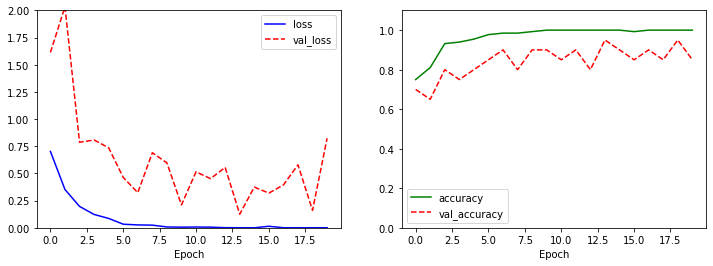

17/17 [==============================] - 9s 524ms/step - loss: 3.2160e-04 - accuracy: 1.0000


[0.00032159831607714295, 1.0]

In [16]:
print(history.history['accuracy'])
print(history.history['val_accuracy'])

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylim(0.0,2)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.0, 1.1)
plt.legend()

plt.show()

model.evaluate(valid_it)
model.evaluate(train_it)

## 결과에 대한 논의

트레이닝 및 검증 정확도 둘 다 상당히 높아야 합니다. 이는 꽤 멋진 결과입니다! 소규모 데이터세트에 대한 트레이닝을 했지만 ImageNet 모델에서 전이된 지식 덕분에 높은 정확도와 적절한 일반화를 달성할 수 있었습니다. 즉, Bo인지 아닌지를 매우 잘 구별할 수 있다는 것입니다.

검증 정확도에서 약간의 변동을 목격했더라도 걱정할 필요 없습니다. 다음 섹션에는 모델 개선을 위한 기술에 대해 이야기하겠습니다.

## 모델 파인튜닝

모델의 새 레이어가 트레이닝되었으므로 이제 [파인튜닝](https://developers.google.com/machine-learning/glossary#f)이라는 마지막 요령을 적용하여 모델을 개선할 수 있습니다. 이렇게 하려면 전체 모델을 동결 해제한 후 아주 작은 [학습률](https://developers.google.com/machine-learning/glossary#learning-rate)로 다시 트레이닝해야 합니다. 그러면 사전 트레이닝된 기본 레이어가 아주 작은 단계를 취해 약간씩 조정되면서 모델이 조금씩 개선됩니다.  

이 단계는 동결된 레이어를 포함하는 모델이 완전히 트레이닝된 후에만 수행해야 합니다. 앞서 모델에 추가한 트레이닝되지 않은 풀링 및 분류 레이어는 임의로 초기화되었습니다. 즉, 이미지를 올바르게 분류하기 위해서는 이 두 레이어에 꽤 많은 업데이트가 필요합니다. [역전파](https://developers.google.com/machine-learning/glossary#backpropagation) 프로세스 과정에서 마지막 레이어의 대규모 초기 업데이트가 사전 트레이닝된 레이어에서도 대규모 업데이트를 초래했을 가능성이 있습니다. 이러한 업데이트는 중요한 사전 트레이닝된 피처를 손상시켰을 것입니다. 하지만 최종 레이어가 트레이닝되고 수렴된 만큼 모델에 대한 업데이트 전체가 크게 축소되어(특히 매우 작은 학습률로) 이전 레이어의 피처를 손상시키지 않을 것입니다.

사전 트레이닝된 레이어를 동결 해제한 다음 모델을 파인튜닝해 보겠습니다.

In [12]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [13]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=10)

Epoch 1/10
12/12 [==============================] - 26s 2s/step - loss: 0.0095 - binary_accuracy: 1.0000 - val_loss: 0.0236 - val_binary_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 27s 2s/step - loss: 1.5620e-04 - binary_accuracy: 1.0000 - val_loss: 0.0578 - val_binary_accuracy: 0.9500
Epoch 3/10
12/12 [==============================] - 28s 2s/step - loss: 6.3134e-05 - binary_accuracy: 1.0000 - val_loss: 0.1348 - val_binary_accuracy: 0.9500
Epoch 4/10
12/12 [==============================] - 28s 2s/step - loss: 4.3852e-06 - binary_accuracy: 1.0000 - val_loss: 0.0461 - val_binary_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 30s 3s/step - loss: 1.4681e-06 - binary_accuracy: 1.0000 - val_loss: 0.1109 - val_binary_accuracy: 0.9500
Epoch 6/10
12/12 [==============================] - 30s 3s/step - loss: 1.8024e-05 - binary_accuracy: 1.0000 - val_loss: 0.0244 - val_binary_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 28s 

## 예측 검사

잘 트레이닝된 모델이 준비되었으니 이제 Bo를 위한 개구멍을 만들어야 합니다! 먼저 모델이 제공하는 예측부터 살펴보겠습니다. 이미지는 지난 개구멍의 경우와 동일한 방식으로 사전 처리하겠습니다.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

몇 개의 이미지에 시도하여 예측을 확인하십시오.

array([[-19.333513]], dtype=float32)

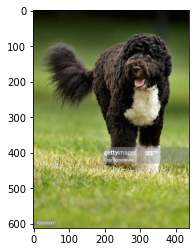

In [13]:
make_predictions('data/presidential_doggy_door/vaild/bo/bo_20.jpg')

array([[23.661366]], dtype=float32)

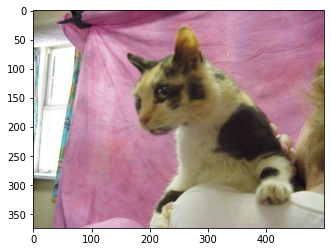

In [18]:
make_predictions('data/presidential_doggy_door/valid/not_bo/121.jpg')

음수 예측은 Bo, 양수 예측은 다른 동물을 의미하는 것으로 보입니다. 이 정보를 사용하여 개구멍에 Bo만 들어가도록 할 수 있습니다! 

## 연습: Bo 분류기

다음 코드를 작성하여 Bo 분류기를 구현하십시오.

In [19]:
def presidential_doggy_door(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")

# def presidential_doggy_door(image_path):
#     preds = make_predictions(image_path)
#     if FIXME:
#         print("It's Bo! Let him in!")
#     else:
#         print("That's not Bo! Stay out!")

## 솔루션

아래의 '...'를 클릭하면 솔루션이 표시됩니다.

```python
def presidential_doggy_door(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")
```

시도해 보겠습니다!

That's not Bo! Stay out!


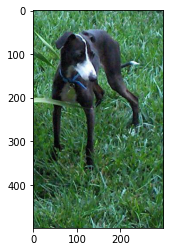

In [20]:
presidential_doggy_door('data/presidential_doggy_door/valid/not_bo/131.jpg')

It's Bo! Let him in!


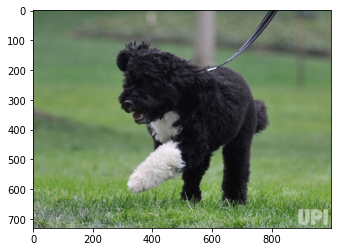

In [21]:
presidential_doggy_door('data/presidential_doggy_door/valid/bo/bo_29.jpg')

## 요약

잘하셨습니다! 전이 학습을 이용하여 아주 작은 데이터세트로 매우 정확한 모델을 구축해 보았습니다. 이는 프로젝트의 성패를 좌우하는 매우 강력한 기술이 될 수 있습니다. 앞으로 비슷한 상황에서 이러한 기술이 도움이 되었으면 합니다!

[NVIDIA 전이 학습 툴킷](https://developer.nvidia.com/tlt-getting-started)에는 전이 학습과 관련된 유용한 많은 리소스가 있습니다.

### 메모리 지우기
넘어가기 전에 다음 셀을 실행하여 GPU 메모리를 지워주시기 바랍니다.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## 다음

지금까지 이 워크숍은 이미지 분류에 주된 초점이 맞춰져 있었습니다. 다음 섹션에서는 딥러닝에 대한 좀 더 포괄적인 소개를 위해 방향을 전환하여 다른 접근 방식을 요하는 순차 데이터 사용에 대해 다루도록 하겠습니다.

이어서 다음 섹션인 [*시퀀스 데이터*](./06_headline_generator.ipynb)를 계속 진행해 주십시오.